# Урок 8. Синтез изображений

## Задание.
Реализовать синтезирование лиц из LFW с помощью DCGAN
Библиотеки: [Python, Tensorflow]

In [1]:
%matplotlib inline
import numpy as np
import pathlib
import matplotlib.pyplot as plt

import tensorflow as tf

2021-10-14 14:33:14.287503: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


## Загрузка и подготовка датасета

In [2]:
# Можно еще вот так распаковать архив.
if 1:
    dataset_url = "http://vis-www.cs.umass.edu/lfw/lfw.tgz"
    data_dir = tf.keras.utils.get_file(origin=dataset_url, fname='lfw', untar=True )
    data_dir = pathlib.Path(data_dir)
else: 
    data_dir = pathlib.Path('lfw')

In [3]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

13233


In [4]:
img_height = 64
img_width = 64

HALF_BATCH_SIZE = 16
BATCH_SIZE = HALF_BATCH_SIZE * 2

In [5]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=HALF_BATCH_SIZE,
  color_mode='grayscale'
)
train_ds = train_ds.shuffle(buffer_size=image_count)


Found 13233 files belonging to 5749 classes.
Using 10587 files for training.


2021-10-14 14:33:19.636760: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-10-14 14:33:19.668409: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-14 14:33:19.669957: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1050 Ti computeCapability: 6.1
coreClock: 1.62GHz coreCount: 6 deviceMemorySize: 3.95GiB deviceMemoryBandwidth: 104.43GiB/s
2021-10-14 14:33:19.670194: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-10-14 14:33:19.683024: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-10-14 14:33:19.683127: I tensorflow/stream_executor/pl

In [6]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  color_mode='grayscale',
  # batch_size=batch_size И тогда разделять ниего не нужно будет.
  )

Found 13233 files belonging to 5749 classes.
Using 2646 files for validation.


## Визуализация датасета

In [7]:
def plot_images(images):
    plt.figure(figsize=(20, 20))
    num = images.shape[0]
    for i in range(num):
       ax = plt.subplot(8, 8, i + 1)
       ax.imshow(images[i], cmap='gray')
       plt.xticks([]), plt.yticks([])
       plt.axis("off")
    plt.show()

2021-10-14 14:33:21.921942: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-10-14 14:33:21.943383: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2799925000 Hz


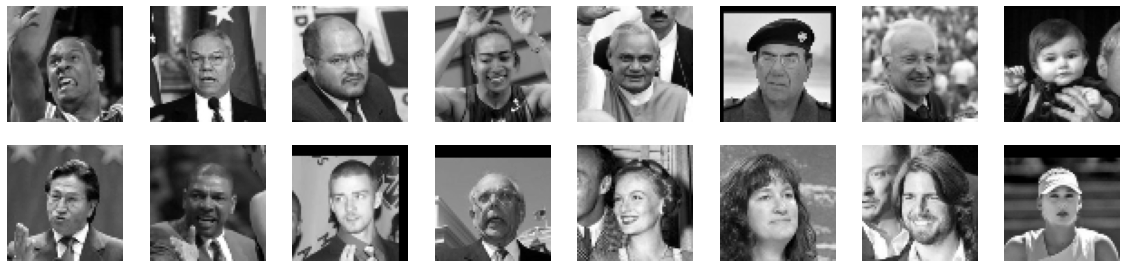

In [8]:
for images, _ in val_ds.take(1):
    plot_images(images[:16])

## Создание Генератора и Дискриминатора

In [9]:
generator = tf.keras.Sequential([
    tf.keras.layers.Dense(128*8*8, activation='relu'),
    tf.keras.layers.Reshape((8, 8, 128)),
    tf.keras.layers.UpSampling2D((2, 2)),    
    tf.keras.layers.Conv2D(128, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(0.2),   
    tf.keras.layers.UpSampling2D((2, 2)),    
    tf.keras.layers.Conv2D(64, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(0.2),  
    tf.keras.layers.UpSampling2D((2, 2)),    
    tf.keras.layers.Conv2D(32, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(0.2),
    tf.keras.layers.Conv2D(1, (3, 3), padding='same', activation='tanh'),
])
#4096
discriminator = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), strides=(2, 2), padding='same'),
    tf.keras.layers.LeakyReLU(0.2),
    tf.keras.layers.Dropout(0.25),    
    tf.keras.layers.Conv2D(64, kernel_size=3, strides=(2, 2), padding='same'),
    tf.keras.layers.ZeroPadding2D(padding=((0, 1), (0, 1))),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(128, kernel_size=3, strides=(2, 2), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(256, kernel_size=3, strides=(1, 1), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1),
])

## Подготовка пайплайна данных и оптимизатора

In [10]:
NUM_EPOCHS = 50
INPUT_DIM = 100
LEARNING_RATE = 0.0002

optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
sigmoid_cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [20]:
noise = np.random.normal(0, 1, (HALF_BATCH_SIZE, INPUT_DIM)).astype(np.float32)
syntetic_images = generator.predict(noise)
print(noise.shape)
print(syntetic_images.shape)

(16, 100)
(16, 64, 64, 1)


In [12]:
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8192)              827392    
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 128)         0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 16, 16, 128)       147584    
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 16, 128)       512       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16, 16, 128)       0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 32, 32, 128)       0

## Обучение GAN

Epoch:  1; D Loss: 0.2783; G Loss: 7.1955


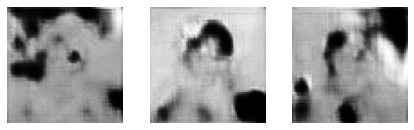

Epoch:  2; D Loss: 0.3649; G Loss: 4.0942
Epoch:  3; D Loss: 0.3021; G Loss: 4.9177
Epoch:  4; D Loss: 0.0994; G Loss: 4.2362
Epoch:  5; D Loss: 0.1438; G Loss: 6.1484
Epoch:  6; D Loss: 0.2715; G Loss: 2.7398


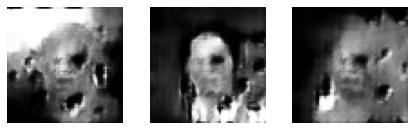

Epoch:  7; D Loss: 0.3485; G Loss: 5.2924
Epoch:  8; D Loss: 0.1503; G Loss: 6.2956
Epoch:  9; D Loss: 0.3595; G Loss: 2.8790
Epoch: 10; D Loss: 0.2361; G Loss: 6.5584
Epoch: 11; D Loss: 0.4521; G Loss: 4.3818


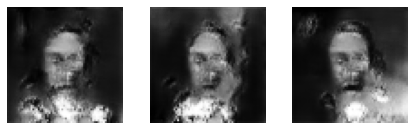

Epoch: 12; D Loss: 0.1106; G Loss: 7.3432
Epoch: 13; D Loss: 0.3619; G Loss: 4.4741
Epoch: 14; D Loss: 0.2321; G Loss: 4.2968
Epoch: 15; D Loss: 0.7286; G Loss: 3.6257
Epoch: 16; D Loss: 0.1599; G Loss: 4.5300


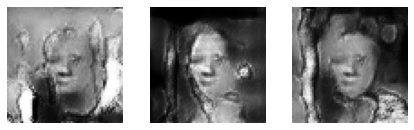

Epoch: 17; D Loss: 0.4462; G Loss: 4.3469
Epoch: 18; D Loss: 0.4587; G Loss: 4.0782
Epoch: 19; D Loss: 0.2155; G Loss: 4.1889
Epoch: 20; D Loss: 0.3277; G Loss: 2.4073
Epoch: 21; D Loss: 0.4141; G Loss: 2.7468


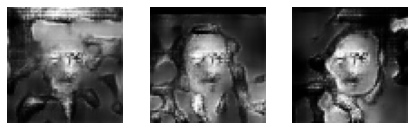

Epoch: 22; D Loss: 0.3160; G Loss: 2.5760
Epoch: 23; D Loss: 0.4746; G Loss: 3.9779
Epoch: 24; D Loss: 0.3282; G Loss: 2.8680
Epoch: 25; D Loss: 0.4099; G Loss: 3.0442
Epoch: 26; D Loss: 0.6706; G Loss: 4.5171


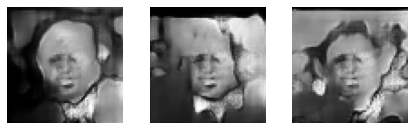

Epoch: 27; D Loss: 0.3517; G Loss: 3.6453
Epoch: 28; D Loss: 0.3964; G Loss: 2.0707
Epoch: 29; D Loss: 0.2006; G Loss: 4.1576
Epoch: 30; D Loss: 0.5158; G Loss: 3.0029
Epoch: 31; D Loss: 0.3288; G Loss: 3.1201


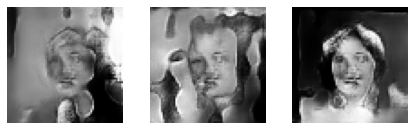

Epoch: 32; D Loss: 0.6330; G Loss: 2.1300
Epoch: 33; D Loss: 0.4338; G Loss: 2.8755
Epoch: 34; D Loss: 0.3507; G Loss: 2.5036
Epoch: 35; D Loss: 0.3682; G Loss: 2.5580
Epoch: 36; D Loss: 0.4442; G Loss: 3.4979


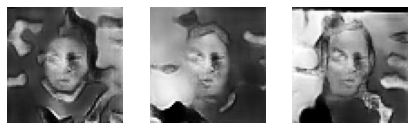

Epoch: 37; D Loss: 0.4374; G Loss: 2.2240
Epoch: 38; D Loss: 0.5287; G Loss: 3.2205
Epoch: 39; D Loss: 0.4817; G Loss: 3.2760
Epoch: 40; D Loss: 0.2464; G Loss: 2.6632
Epoch: 41; D Loss: 0.5192; G Loss: 2.6648


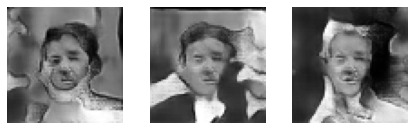

Epoch: 42; D Loss: 0.4309; G Loss: 2.3782
Epoch: 43; D Loss: 0.3220; G Loss: 2.8439
Epoch: 44; D Loss: 0.2470; G Loss: 2.6707
Epoch: 45; D Loss: 0.4592; G Loss: 1.9360
Epoch: 46; D Loss: 0.5596; G Loss: 2.3495


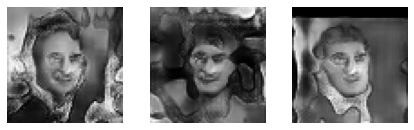

Epoch: 47; D Loss: 0.3425; G Loss: 2.2490
Epoch: 48; D Loss: 0.5658; G Loss: 2.1662
Epoch: 49; D Loss: 0.4857; G Loss: 1.9181
Epoch: 50; D Loss: 0.4875; G Loss: 1.2108


In [14]:
for epoch in range(NUM_EPOCHS):
    # print(f'EPOCH:{epoch+1}')
    for step, (true_images,_) in enumerate(train_ds):
        try:
            # Train Discriminator
            true_images=(true_images-127.5)/127.5
            # if(images)
            # true_images = (tf.reshape(true_images, [-1, img_height*img_width]) - 127.5) / 127.5
            noise = np.random.normal(0, 1, (HALF_BATCH_SIZE, INPUT_DIM)).astype(np.float32)
            syntetic_images = generator.predict(noise)
            x_combined = np.concatenate((
                true_images, 
                syntetic_images))
            y_combined = np.concatenate((
                np.ones((HALF_BATCH_SIZE, 1), np.float32), 
                np.zeros((HALF_BATCH_SIZE, 1), np.float32)))
            
            with tf.GradientTape() as tape:
                logits = discriminator(x_combined, training=True)
                d_loss_value = sigmoid_cross_entropy(y_combined, logits)
            grads = tape.gradient(d_loss_value, discriminator.trainable_variables)
            optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))
            
            # Train Generator
            
            noise = np.random.normal(0, 1, (BATCH_SIZE, INPUT_DIM)).astype(np.float32)
            y_mislabled = np.ones((BATCH_SIZE, 1), np.float32)
            
            with tf.GradientTape() as tape:
                syntetic = generator(noise, training=True)
                logits = discriminator(syntetic, training=False)
                g_loss_value = sigmoid_cross_entropy(y_mislabled, logits)
            grads = tape.gradient(g_loss_value, generator.trainable_variables)
            optimizer.apply_gradients(zip(grads, generator.trainable_variables))
            
        except Exception as ex:
            # print(ex)
            pass
    # Check intermediate results
    print('Epoch: %2d; D Loss: %.4f; G Loss: %.4f' % (epoch+1, d_loss_value.numpy(), g_loss_value.numpy()))
    if epoch % 5==0:
        noise = np.random.normal(0, 1, (3, INPUT_DIM)).astype(np.float32)
        syntetic_images = generator.predict(noise)
        plot_images(syntetic_images)

Epoch:  1; D Loss: 0.6064; G Loss: 2.6261


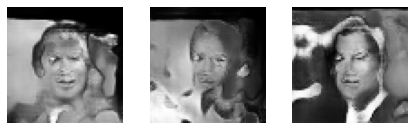

Epoch:  2; D Loss: 0.2950; G Loss: 2.2687
Epoch:  3; D Loss: 0.4170; G Loss: 2.4819
Epoch:  4; D Loss: 0.6916; G Loss: 2.7237
Epoch:  5; D Loss: 0.6423; G Loss: 2.1023
Epoch:  6; D Loss: 0.4682; G Loss: 2.7166


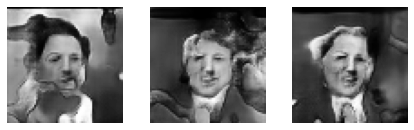

Epoch:  7; D Loss: 0.4459; G Loss: 3.1981
Epoch:  8; D Loss: 0.3010; G Loss: 2.0425
Epoch:  9; D Loss: 0.4519; G Loss: 2.0883
Epoch: 10; D Loss: 0.6730; G Loss: 2.2931
Epoch: 11; D Loss: 0.3450; G Loss: 2.2461


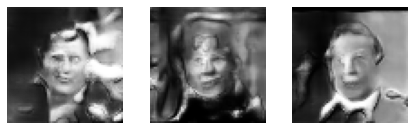

Epoch: 12; D Loss: 0.5287; G Loss: 2.2053
Epoch: 13; D Loss: 0.5299; G Loss: 2.0487
Epoch: 14; D Loss: 0.5074; G Loss: 1.8840
Epoch: 15; D Loss: 0.6848; G Loss: 2.5864
Epoch: 16; D Loss: 0.6962; G Loss: 2.1575


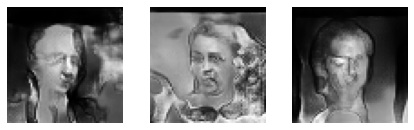

Epoch: 17; D Loss: 0.6739; G Loss: 1.7679
Epoch: 18; D Loss: 0.5495; G Loss: 1.6054
Epoch: 19; D Loss: 0.3784; G Loss: 1.9932
Epoch: 20; D Loss: 0.4173; G Loss: 1.5456
Epoch: 21; D Loss: 0.6225; G Loss: 2.3769


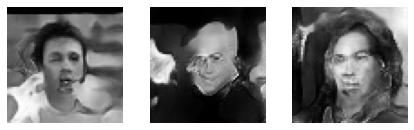

Epoch: 22; D Loss: 0.7101; G Loss: 2.4735
Epoch: 23; D Loss: 0.5035; G Loss: 1.4424
Epoch: 24; D Loss: 0.5744; G Loss: 1.7310
Epoch: 25; D Loss: 0.5008; G Loss: 1.6291
Epoch: 26; D Loss: 0.5605; G Loss: 1.6911


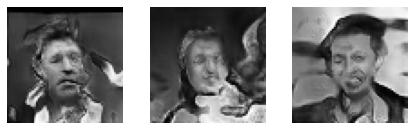

Epoch: 27; D Loss: 0.5311; G Loss: 1.7064
Epoch: 28; D Loss: 0.6395; G Loss: 1.7634
Epoch: 29; D Loss: 0.4000; G Loss: 1.7230
Epoch: 30; D Loss: 0.4819; G Loss: 1.5888
Epoch: 31; D Loss: 0.5404; G Loss: 1.5983


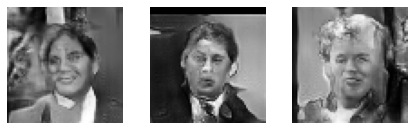

Epoch: 32; D Loss: 0.5558; G Loss: 1.5581
Epoch: 33; D Loss: 0.6201; G Loss: 1.4315
Epoch: 34; D Loss: 0.5253; G Loss: 1.7760
Epoch: 35; D Loss: 0.6157; G Loss: 1.2099
Epoch: 36; D Loss: 0.6087; G Loss: 1.7161


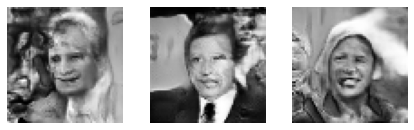

Epoch: 37; D Loss: 0.5466; G Loss: 1.8049
Epoch: 38; D Loss: 0.5568; G Loss: 1.5270
Epoch: 39; D Loss: 0.4952; G Loss: 1.6700
Epoch: 40; D Loss: 0.5103; G Loss: 1.2759
Epoch: 41; D Loss: 0.6159; G Loss: 1.8768


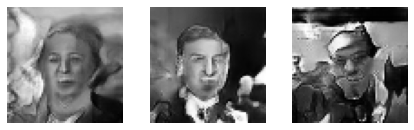

Epoch: 42; D Loss: 0.4388; G Loss: 1.3436
Epoch: 43; D Loss: 0.5911; G Loss: 1.5873
Epoch: 44; D Loss: 0.4743; G Loss: 1.7206
Epoch: 45; D Loss: 0.6533; G Loss: 1.8466
Epoch: 46; D Loss: 0.7179; G Loss: 1.8539


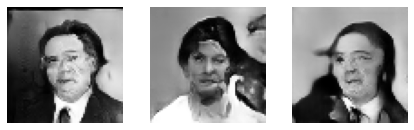

Epoch: 47; D Loss: 0.5766; G Loss: 1.7600
Epoch: 48; D Loss: 0.7509; G Loss: 1.5263
Epoch: 49; D Loss: 0.4907; G Loss: 2.0622
Epoch: 50; D Loss: 0.5472; G Loss: 1.3145


In [17]:
for epoch in range(NUM_EPOCHS):
    # print(f'EPOCH:{epoch+1}')
    for step, (true_images,_) in enumerate(train_ds):
        try:
            # Train Discriminator
            true_images=(true_images-127.5)/127.5
            # if(images)
            # true_images = (tf.reshape(true_images, [-1, img_height*img_width]) - 127.5) / 127.5
            noise = np.random.normal(0, 1, (HALF_BATCH_SIZE, INPUT_DIM)).astype(np.float32)
            syntetic_images = generator.predict(noise)
            x_combined = np.concatenate((
                true_images, 
                syntetic_images))
            y_combined = np.concatenate((
                np.ones((HALF_BATCH_SIZE, 1), np.float32), 
                np.zeros((HALF_BATCH_SIZE, 1), np.float32)))
            
            with tf.GradientTape() as tape:
                logits = discriminator(x_combined, training=True)
                d_loss_value = sigmoid_cross_entropy(y_combined, logits)
            grads = tape.gradient(d_loss_value, discriminator.trainable_variables)
            optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))
            
            # Train Generator
            
            noise = np.random.normal(0, 1, (BATCH_SIZE, INPUT_DIM)).astype(np.float32)
            y_mislabled = np.ones((BATCH_SIZE, 1), np.float32)
            
            with tf.GradientTape() as tape:
                syntetic = generator(noise, training=True)
                logits = discriminator(syntetic, training=False)
                g_loss_value = sigmoid_cross_entropy(y_mislabled, logits)
            grads = tape.gradient(g_loss_value, generator.trainable_variables)
            optimizer.apply_gradients(zip(grads, generator.trainable_variables))
            
        except Exception as ex:
            # print(ex)
            pass
    # Check intermediate results
    print('Epoch: %2d; D Loss: %.4f; G Loss: %.4f' % (epoch+1, d_loss_value.numpy(), g_loss_value.numpy()))
    if epoch % 5==0:
        noise = np.random.normal(0, 1, (3, INPUT_DIM)).astype(np.float32)
        syntetic_images = generator.predict(noise)
        plot_images(syntetic_images)

## Тестирование свёрточного генератора

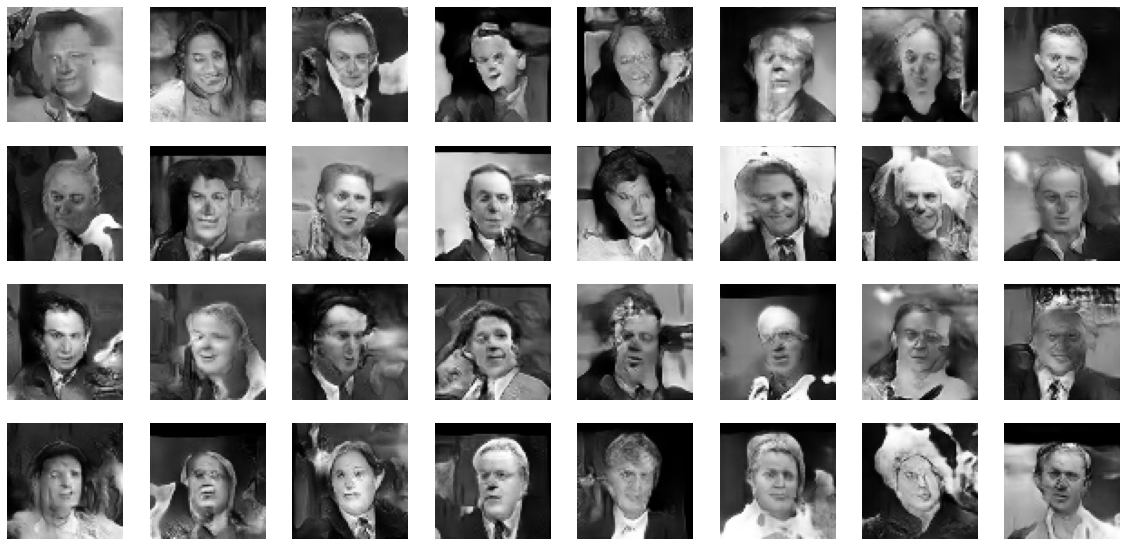

In [18]:
noise = np.random.normal(0, 1, (32, INPUT_DIM)).astype(np.float32)
syntetic_images = generator.predict(noise)
plot_images(syntetic_images)

## Интерполяция в латентном пространстве

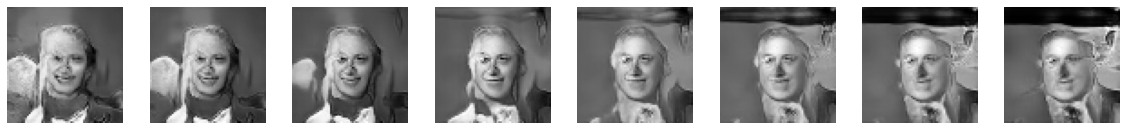

In [19]:
noise_1 = np.random.normal(0, 1, (INPUT_DIM)).astype(np.float32)
noise_2 = np.random.normal(0, 1, (INPUT_DIM)).astype(np.float32)
noise = np.linspace(noise_1, noise_2, 8)
syntetic_images = generator.predict(noise)
plot_images(syntetic_images)